In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import hyperspy.api as hys
from sklearn.decomposition import NMF, KernelPCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, OPTICS, cluster_optics_dbscan
import malspy
import tkinter.filedialog as tkf
import ipywidgets as pyw
from tabulate import tabulate

In [ ]:
%matplotlib inline

In [2]:
def remove_negative_med_shift(img):
    if np.min(img) < 0:
        ri = np.where(img < 0)
        neg_med = np.median(img[ri])
        img += -neg_med
    img = img.clip(min=0.0)
        
    return img

In [3]:
def warp_scale(spectrum):
    spectrum = spectrum.clip(min=0.0)
    min_val = np.min(spectrum)
    
    rescaled = spectrum - min_val
    
    if np.max(rescaled) != 0:
        rescaled = rescaled / np.max(rescaled)
    
    return rescaled

In [4]:
dm_files = tkf.askopenfilenames()
print(len(dm_files))
print(dm_files)

3
('E:/data_temporary/20190925_DGIST/processed_data/processed_data_variance_mean/no_normalization/B1_2_scan_x256_y256_radial_var_radial_no_normalization.hdf5', 'E:/data_temporary/20190925_DGIST/processed_data/processed_data_variance_mean/no_normalization/B1_3_scan_x256_y256_radial_var_radial_no_normalization.hdf5', 'E:/data_temporary/20190925_DGIST/processed_data/processed_data_variance_mean/no_normalization/B1_4_scan_x256_y256_radial_var_radial_no_normalization.hdf5')


In [ ]:
dm_files = list(dm_files)
dm_files.extend(tkf.askopenfilenames())
print(len(dm_files))
print(dm_files)

In [ ]:
dm_files = list(dm_files)
dm_files.extend(tkf.askopenfilenames())
print(len(dm_files))
print(dm_files)

In [5]:
# just load data
dataset = []
data_shape = []
for i, adr in enumerate(dm_files):
    temp = hys.load(adr)
    temp = temp.data[:, :, 20:60]
    print(temp.shape)
    
    data_shape.append(temp.shape)
    dataset.append(temp)

(252, 43, 40)
(253, 38, 40)
(252, 43, 40)


In [ ]:
# load data, remove negative values and rescale data
dataset = []
data_shape = []
for i, adr in enumerate(dm_files):
    temp = hys.load(adr)
    temp = temp.data
    print(temp.shape)
    for j in range(temp.shape[0]):
        for k in range(temp.shape[1]):
            temp[j, k] = warp_scale(remove_negative_med_shift(temp[j, k]))
    data_shape.append(temp.shape)
    dataset.append(temp)

In [6]:
num_img = len(dataset)

data_shape = np.asarray(data_shape)
print(data_shape)
s_dim = np.min(data_shape[:, 2])

data_shape_new = []

data_shape_new = data_shape[:, :2]
print(data_shape_new)
print(s_dim)

[[252  43  40]
 [253  38  40]
 [252  43  40]]
[[252  43]
 [253  38]
 [252  43]]
40


In [7]:
x_range = np.arange(s_dim) # just length of a spectrum
#x_range = np.arange(520, 560, 0.1) # O K edge
#x_range = np.arange(635, 670, 0.1) # Mn L2,3 edge
#x_range = np.arange(450, 480, 0.1) # Ti L2,3 edge
print(len(x_range))

40


In [8]:
img_storage = []

for i in range(num_img):
    img_storage.append(np.sum(dataset[i], axis=2))
            
#for i in range(num_img):
#    plt.imshow(img_storage[i])
#    plt.show()

In [9]:
def colortable(colors, title, sort_colors=True, emptycols=0):
    
    by_hsv = ((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                    for name, color in colors.items())
    if sort_colors is True:
        by_hsv = sorted(by_hsv)
    names = [name for hsv, name in by_hsv]
    
    return names

color_name = colortable(mcolors.CSS4_COLORS, "CSS Colors")
num_color = len(color_name)
print(len(color_name))

ri = np.random.choice(num_color, num_color, replace=False)
ri = np.sort(ri)
print(ri)
color_cand = {}
for i in range(num_color):
    color_cand[i] = color_name[ri[i]]

148
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147]


In [10]:
# only one color
class_group = []
color_group = []
for i in range(num_img):
    for j in range(data_shape_new[i, 0]):
        for k in range(data_shape_new[i, 1]):
            color_group.append("red")

In [11]:
dataset_input = []
for i in range(num_img):
    dataset_input.extend(dataset[i].clip(min=0.0).reshape(-1, s_dim).tolist())
    
dataset_input = np.asarray(dataset_input)
print(dataset_input.shape)

(31286, 40)


In [12]:
color_rep = ["black", "darkgray", "green", "red", "blue", "purple", "orange", "yellow", "lime", "cyan", "magenta", "lightgray", "peru", "springgreen", "deepskyblue", "hotpink"]
print(len(color_rep))
custom_cmap = mcolors.ListedColormap(color_rep)
bounds = np.arange(-1, len(color_rep))
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=len(color_rep))
sm = cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])

16


In [13]:
num_comp = 5

In [ ]:
# https://github.com/MotokiShiga/malspy
# NMF with automatic relevance determination and soft orthogonality penalty
model_nmf_ardso = malspy.NMF_ARD_SO(n_components=num_comp, wo=0.0, reps=3, max_itr=50)
model_nmf_ardso.fit(dataset_input)
model_nmf_ardso.plot_spectra(figsize=(6, 3), normalize=False)
projections = model_nmf_ardso.C_
print(projections.shape)
comp_vectors = model_nmf_ardso.S_
comp_vectors = np.rollaxis(comp_vectors, 1, 0)
print(comp_vectors.shape)
#num_comp = comp_vectors.shape[0]

In [14]:
# https://github.com/MotokiShiga/malspy
# NMF with soft orthogonality penalty
model_nmf_so = malspy.NMF_SO(n_components=num_comp, wo=0.10, reps=5, max_itr=500)
model_nmf_so.fit(dataset_input)
projections = model_nmf_so.C_
print(projections.shape)
comp_vectors = model_nmf_so.S_
comp_vectors = np.rollaxis(comp_vectors, 1, 0)
print(comp_vectors.shape)
#num_comp = comp_vectors.shape[0]

Training NMF with soft orthogonal constraint....
1th iteration of NMF-SO algorithm
# updates: 499
2th iteration of NMF-SO algorithm
# updates: 499
3th iteration of NMF-SO algorithm
# updates: 424
4th iteration of NMF-SO algorithm
# updates: 499
5th iteration of NMF-SO algorithm
# updates: 253
(31286, 5)
(5, 40)


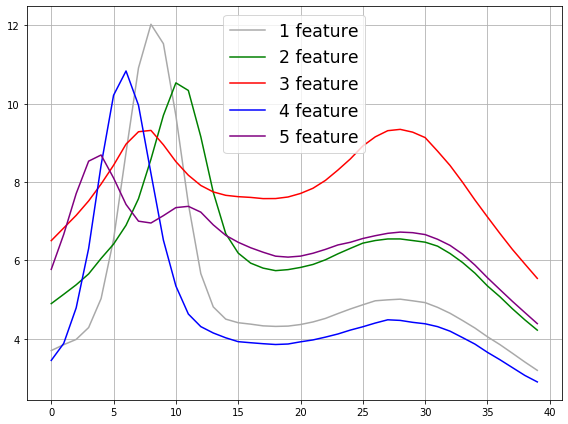

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i in range(num_comp):
    ax.plot(comp_vectors[i], "-", c=color_rep[i+1], label="%d feature"%(i+1))
ax.grid()
ax.legend(fontsize="xx-large")
#ax.set_facecolor("black")
fig.tight_layout()
plt.show()

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
nmf_num_comp = num_comp
skl_nmf = NMF(n_components=num_comp, init="nndsvda", solver="mu", max_iter=1000, 
              random_state=np.random.randint(100), verbose=True, beta_loss="frobenius", l1_ratio=0.1, alpha=0.0)

nmf_projections = skl_nmf.fit_transform(dataset_input)
nmf_comps = skl_nmf.components_
print(nmf_projections.shape)
print(nmf_comps.shape)

In [ ]:
num_comp = nmf_num_comp
comp_vectors = nmf_comps
projections = nmf_projections

In [ ]:
%matplotlib inline

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i in range(num_comp):
    ax.plot(comp_vectors[i], "-", c=color_rep[i+1], label="%d component"%(i+1))
ax.grid()
ax.legend(fontsize="xx-large")
#ax.set_facecolor("black")
fig.tight_layout()
plt.show()

In [ ]:
plt.close(fig)

In [ ]:
%matplotlib inline

[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 31286 samples in 0.359s...
[t-SNE] Computed neighbors for 31286 samples in 4.289s...
[t-SNE] Computed conditional probabilities for sample 1000 / 31286
[t-SNE] Computed conditional probabilities for sample 2000 / 31286
[t-SNE] Computed conditional probabilities for sample 3000 / 31286
[t-SNE] Computed conditional probabilities for sample 4000 / 31286
[t-SNE] Computed conditional probabilities for sample 5000 / 31286
[t-SNE] Computed conditional probabilities for sample 6000 / 31286
[t-SNE] Computed conditional probabilities for sample 7000 / 31286
[t-SNE] Computed conditional probabilities for sample 8000 / 31286
[t-SNE] Computed conditional probabilities for sample 9000 / 31286
[t-SNE] Computed conditional probabilities for sample 10000 / 31286
[t-SNE] Computed conditional probabilities for sample 11000 / 31286
[t-SNE] Computed conditional probabilities for sample 12000 / 31286
[t-SNE] Computed conditional probabilities for sa

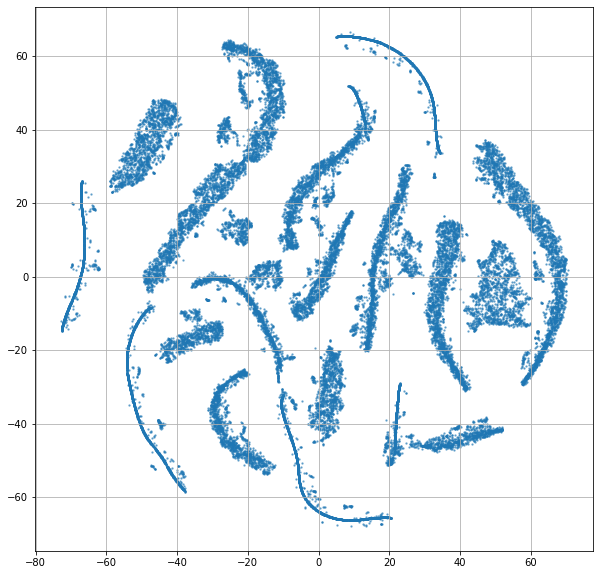

In [16]:
num_comp_vis = 2
tsne = TSNE(n_components=num_comp_vis, perplexity=150, early_exaggeration=5.0, learning_rate=300.0, 
                init="random", n_iter=1000, verbose=2, random_state=np.random.randint(100))
tsne.fit_transform(projections)
embedding = tsne.embedding_
print(embedding.shape)

if num_comp_vis == 2:
    plt.figure(figsize=(10, 10))
    plt.scatter(embedding[:, 0], embedding[:, 1], s=2, alpha=0.5)
    plt.grid()
    plt.show()
    
elif num_comp_vis == 3:
    plt.figure(figsize=(10, 10))
    plt.scatter(embedding[:, 0], embedding[:, 1], s=2, alpha=0.5)
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(10, 10))
    plt.scatter(embedding[:, 1], embedding[:, 2], s=2, alpha=0.5)
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(10, 10))
    plt.scatter(embedding[:, 0], embedding[:, 2], s=2, alpha=0.5)
    plt.grid()
    plt.show()

In [17]:
num_comp = num_comp_vis
projections = embedding

In [ ]:
%matplotlib qt
fig_3d = plt.figure(figsize=(10, 10))
ax_3d = fig_3d.add_subplot(111, projection="3d")
ax_3d.scatter(projections[:, 0], projections[:, 1], projections[:, 2], s=5, alpha=0.5, c="black")
ax_3d.set_xlabel("component 1", fontsize=20)
ax_3d.set_ylabel("component 2", fontsize=20)
ax_3d.set_zlabel("component 3", fontsize=20)
ax_3d.grid()
fig_3d.tight_layout()
plt.show()

In [18]:
projections_copy = projections.copy()
print(projections_copy.shape)
projection_reshape = []
for i in range(num_img):
    temp = projections_copy[:int(data_shape_new[i, 0]*data_shape_new[i, 1]), :]
    print(temp.shape)
    projections_copy = np.delete(projections_copy, range(int(data_shape_new[i, 0]*data_shape_new[i, 1])), axis=0)
    print(projections_copy.shape)
    temp = np.reshape(temp, (data_shape_new[i, 0], data_shape_new[i, 1], -1))
    print(temp.shape)
    projection_reshape.append(temp)

(31286, 2)
(10836, 2)
(20450, 2)
(252, 43, 2)
(9614, 2)
(10836, 2)
(253, 38, 2)
(10836, 2)
(0, 2)
(252, 43, 2)


In [19]:
cluster_ax_1 = 0
cluster_ax_2 = 1
X = np.stack((projections[:, cluster_ax_1], projections[:, cluster_ax_2]), axis=1)
print(X.shape)

(31286, 2)


In [ ]:
# for 3-dimensional case
cluster_ax_1 = 0
cluster_ax_2 = 1
cluster_ax_3 = 2
X = np.stack((projections[:, cluster_ax_1], projections[:, cluster_ax_2], projections[:, cluster_ax_3]), axis=1)
print(X.shape)

In [ ]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html#sphx-glr-auto-examples-cluster-plot-optics-py
# Ordering Points To Identify the Clustering Structure

clust = OPTICS(min_samples=.05, xi=.0001, min_cluster_size=.05).fit(X)
space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(15, 8))
# Reachability plot
colors = color_rep
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    plt.plot(Xk, Rk, color, alpha=0.3)
plt.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
plt.grid()
plt.title('Reachability Plot')
plt.show()

In [ ]:
%matplotlib inline

In [ ]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html#sphx-glr-auto-examples-cluster-plot-optics-py
# 2-dimensional case
ep1 = 15.0
ep2 = 13.0
labels_1 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=ep1)
labels_2 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=ep2)

fig8 = plt.figure(figsize=(15, 10))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
for klass, color in zip(range(0, len(colors)), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color=color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, ep1, dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, ep2, dtype=float), 'k-.', alpha=0.5)
ax1.grid()
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
for klass, color in zip(range(0, len(colors)), colors):
    Xk = X[clust.labels_ == klass]
    ax2.scatter(Xk[:, 0], Xk[:, 1], color=color, alpha=0.3, marker='.')
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS(# of clusters=%d)'%(len(np.unique(clust.labels_))))

# DBSCAN 1
for klass, color in zip(range(0, len(colors)), colors):
    Xk = X[labels_1 == klass]
    ax3.scatter(Xk[:, 0], Xk[:, 1], color=color, alpha=0.3, marker='.')
ax3.plot(X[labels_1 == -1, 0], X[labels_1 == -1, 1], 'k+', alpha=0.1)
ax3.set_title('Clustering at %.1f epsilon cut\nDBSCAN(# of clusters=%d)'%(ep1, len(np.unique(labels_1))))

# DBSCAN 2.
for klass, color in zip(range(0, len(colors)), colors):
    Xk = X[labels_2 == klass]
    ax4.scatter(Xk[:, 0], Xk[:, 1], color=color, alpha=0.3, marker='.')
ax4.plot(X[labels_2 == -1, 0], X[labels_2 == -1, 1], 'k+', alpha=0.1)
ax4.set_title('Clustering at %.1f epsilon cut\nDBSCAN(# of clusters=%d)'%(ep2, len(np.unique(labels_2))))

fig8.tight_layout()
plt.show()

In [ ]:
%matplotlib qt
# https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html#sphx-glr-auto-examples-cluster-plot-optics-py
# 3-dimensional case
ep1 = 5.0
ep2 = 6.0
labels_1 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=ep1)
labels_2 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=ep2)

fig8 = plt.figure(figsize=(15, 10))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0], projection="3d")
ax3 = plt.subplot(G[1, 1], projection="3d")
ax4 = plt.subplot(G[1, 2], projection="3d")

# Reachability plot
for klass, color in zip(range(0, len(colors)), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color=color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, ep1, dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, ep2, dtype=float), 'k-.', alpha=0.5)
ax1.grid()
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
for klass, color in zip(range(0, len(colors)), colors):
    Xk = X[clust.labels_ == klass]
    ax2.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], color=color, alpha=0.3, marker='.')
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS(# of clusters=%d)'%(len(np.unique(clust.labels_))))

# DBSCAN 1
for klass, color in zip(range(0, len(colors)), colors):
    Xk = X[labels_1 == klass]
    ax3.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], color=color, alpha=0.3, marker='.')
ax3.plot(X[labels_1 == -1, 0], X[labels_1 == -1, 1], 'k+', alpha=0.1)
ax3.set_title('Clustering at %.1f epsilon cut\nDBSCAN(# of clusters=%d)'%(ep1, len(np.unique(labels_1))))

# DBSCAN 2.
for klass, color in zip(range(0, len(colors)), colors):
    Xk = X[labels_2 == klass]
    ax4.scatter(Xk[:, 0], Xk[:, 1],  Xk[:, 2], color=color, alpha=0.3, marker='.')
ax4.plot(X[labels_2 == -1, 0], X[labels_2 == -1, 1], 'k+', alpha=0.1)
ax4.set_title('Clustering at %.1f epsilon cut\nDBSCAN(# of clusters=%d)'%(ep2, len(np.unique(labels_2))))

fig8.tight_layout()
plt.show()

Estimated number of clusters: 13
Estimated number of noise points: 43


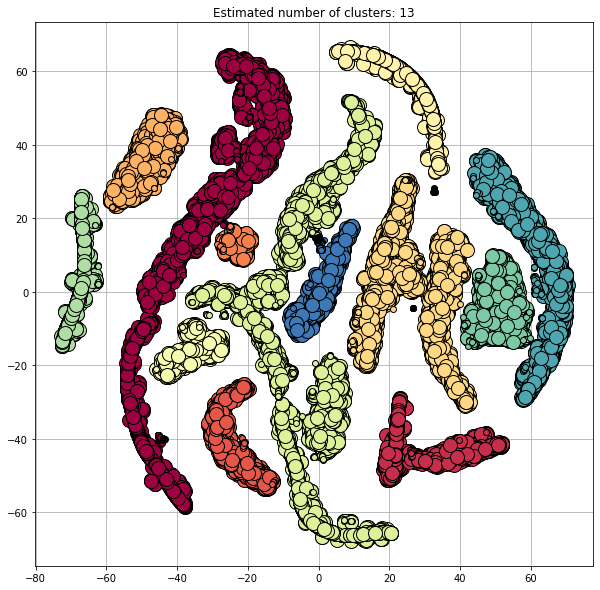

In [22]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
# clustering using DBSCAN (Density-based Spatial Clustering of Applications with Noise)
# 2-dimensional case

db = DBSCAN(eps=4.0, min_samples=100).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
db_labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

plt.figure(figsize=(10, 10))
# Black removed and is used for noise instead.
unique_labels = set(db_labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (db_labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
    
plt.grid()
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
# clustering using DBSCAN (Density-based Spatial Clustering of Applications with Noise)
# 3-dimensional case
%matplotlib qt
db = DBSCAN(eps=5.75, min_samples=500).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
db_labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
#ax.set_xlabel("component 1", fontsize=20)
#ax.set_ylabel("component 2", fontsize=20)
#ax.set_zlabel("component 3", fontsize=20)

# Black removed and is used for noise instead.
unique_labels = set(db_labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (db_labels == k)

    xy = X[class_member_mask & core_samples_mask]
    ax.plot(xy[:, 0], xy[:, 1], xy[:, 2], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    ax.plot(xy[:, 0], xy[:, 1], xy[:, 2], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
    
ax.grid()
#ax.title('Estimated number of clusters: %d' % n_clusters_)
fig.tight_layout()
fig.show()

In [23]:
#label_selected = labels_1
#label_selected = labels_2
#label_selected = clust.labels_.copy()
label_selected = db_labels
label_sort = np.unique(label_selected)
print(label_sort)
num_label = len(label_sort)
label_copy = label_selected.copy()
print(label_copy.shape)
hist, edge = np.histogram(label_selected, bins=num_label)
print(len(hist))
print(hist)
label_reshape = []
for i in range(num_img):
    temp = label_copy[:int(data_shape_new[i, 0]*data_shape_new[i, 1])]
    #print(temp.shape)
    label_copy = np.delete(label_copy, range(int(data_shape_new[i, 0]*data_shape_new[i, 1])), axis=0)
    #print(label_copy.shape)
    temp = np.reshape(temp, (data_shape_new[i, 0], data_shape_new[i, 1]))
    #print(temp.shape)
    label_reshape.append(temp)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12]
(31286,)
14
[  43 5724 1674 1391  360 1574 4287 1449  915 6766 1308 1451 3027 1317]


In [24]:
selected = []
for i in range(num_label):
    temp = []
    for j in range(num_img):
        #print(i, label_sort[i], j)
        img_temp = np.array(label_reshape[j]).copy()
        img_temp[np.where(img_temp != label_sort[i])] = -10
        img_temp[np.where(img_temp == label_sort[i])] = 1
        img_temp[np.where(img_temp == -10)] = 0
        #print(len(np.nonzero(img_temp)[0]))
        temp.append(img_temp)
    selected.append(temp)

In [ ]:
%matplotlib qt
fig10, ax10 = plt.subplots(1, num_img, figsize=(10, 7))
if num_img != 1:
    for i, axs in enumerate(ax10):
        axs.imshow(label_reshape[i], cmap=custom_cmap, norm=norm)
        axs.set_title("image %d"%(i+1), fontsize=20)
        axs.axis("off")

else:
    ax10.imshow(label_reshape[0], cmap=custom_cmap, norm=norm)
    ax10.set_title("image %d"%(1), fontsize=20)
    ax10.axis("off")
fig10.colorbar(sm)
fig10.tight_layout()

In [ ]:
%matplotlib qt
fig9, ax9 = plt.subplots(1, num_img, figsize=(8, 6))
    
def map_selector(label):
    if num_img != 1:
        for i, axs in enumerate(ax9):
            axs.cla()
            axs.imshow(selected[label][i], cmap="afmhot")
            axs.set_title("label %d map"%(label_sort[label]), fontsize=10)
            axs.axis("off")
            
    else:
        ax9.cla()
        ax9.imshow(selected[label][0], cmap="afmhot")
        ax9.set_title("label %d map"%(label_sort[label]), fontsize=10)
        ax9.axis("off")
    
    fig9.canvas.draw()
    fig9.tight_layout()
    
pyw.interact(map_selector, label=pyw.IntSlider(min=0, max=num_label-1, step=1, value=0))
fig9.show()

In [26]:
num_sel = num_label

In [25]:
# assume the shape of clusters is circle

def cluster_size(img):
    label = np.unique(img)
    label =  label[label != -1]
    #print(label)
    cluster_size = []
    for i in label:
        cluster_size.append(len(np.where(img==i)[0]))
    cluster_size = np.sort(cluster_size)
    #print(cluster_size)

    largest = 2*np.sqrt(cluster_size[-1]/np.pi)
    smallest = 2*np.sqrt(cluster_size[0]/np.pi)
    avg = 2*np.sqrt(np.mean(cluster_size)/np.pi)
    avg_peri = 2*np.sqrt(np.mean(cluster_size)*np.pi)
    
    return avg, avg_peri, largest, smallest

In [29]:
%matplotlib qt
r_per_pixel = 0.400
fig12, ax12 = plt.subplots(1, 2, figsize=(10, 10))
row_label = ["area (%)", "# of clusters", "mean size (pixels)", "largest size (pixels)", "smallest size (pixels)"]

def selector(m, e, label, n_img):
    db = DBSCAN(eps=e, min_samples=m)
    label -= 1
    n_img -= 1

    ax12[0].cla()
    ax12[1].cla()
    #ax12[2].cla()
    
    ax12[0].imshow(selected[label][n_img], cmap="afmhot")
    ax12[0].axis("off")  
    
    sel_coor = np.nonzero(selected[label][n_img])
    X = np.stack((sel_coor[0], sel_coor[1]), axis=1)
    db.fit(X)
    dblabel = db.labels_
    img_tmp = np.zeros_like(selected[label][n_img])
    img_tmp += -1
    img_tmp[X[:, 0], X[:, 1]] = dblabel
    bool_img = np.where(img_tmp<0, img_tmp, 1)
    bool_img = np.where(bool_img>-1, bool_img, 0)
    #ax12[1].set_title("label %d, image %d, epsilon=%.1f, min_#_of_samples=%d"%(label, n_img, e, m), fontsize=15)
    ax12[1].imshow(bool_img, cmap="afmhot")
    ax12[1].axis("off")
    
    area = np.around(100 * np.sum(bool_img) / (img_tmp.shape[0]*img_tmp.shape[1]), decimals=2)
    print("area of the roi = %.2f"%(img_tmp.shape[0]*img_tmp.shape[1]*r_per_pixel**2))
    per_10000sqnm = 10000 / (img_tmp.shape[0]*img_tmp.shape[1]*r_per_pixel**2)
    n_cluster = np.around((len(np.unique(dblabel)) - 1) * per_10000sqnm, decimals=0)
    if n_cluster != 0:
        avg, avg_peri, largest, smallest = cluster_size(img_tmp)
        avg = np.around(avg*r_per_pixel, decimals=2)
        avg_peri = np.around(avg_peri*r_per_pixel, decimals=2)
        largest = np.around(largest*r_per_pixel, decimals=2)
        smallest = np.around(smallest*r_per_pixel, decimals=2)
        table_vals = [[area], [n_cluster], [avg], [largest], [smallest]]
        print("----------------------------------------")
        print("label %d, image %d"%(label+1, n_img+1))
        print("epsilon=%.1f, minimum # of samples=%d"%(e, m))
        print(tabulate([["area (%)", area], ["# of cluster (per 10000 nm^2)", n_cluster], ["mean perimeter", avg_peri], 
                        ["mean size", avg], ["largest size", largest], ["smallest size", smallest]]))
        #table = ax3[2].table(cellText=table_vals, rowLabels=row_label, loc="center", 
        #                     rowLoc="center", cellLoc="center", colWidths=[0.1]*3)
        #table.scale(3, 8)
        #table.auto_set_font_size(False)
        #table.set_fontsize(15)
        
    else:
        print("----------------------------------------")
        print("there is no clusters")
    
    #table = ax12[2].table(cellText=table_vals, rowLabels=row_label, loc="center", rowLoc="center", cellLoc="center", colWidths=[0.1]*3)
    #table.scale(3, 8)
    #table.auto_set_font_size(False)
    #table.set_fontsize(25)
    #ax12[2].axis("off")
    fig12.tight_layout()

st = {"description_width": "initial"}
min_widget = pyw.IntSlider(value=4, min=0, max=10, step=1, description="minimum # of cluster pixels", style=st)
eps_widget = pyw.FloatSlider(value=1.5, min=1.0, max=2.0, step=0.1, description="epsilon: ", style=st)
label_widget = pyw.Dropdown(options=np.arange(num_label)+1, value = 1, description="label: ", style=st)
n_img_widget = pyw.Dropdown(options=np.arange(num_img)+1, value = 1, description="image: ", style=st)

pyw.interact(selector, m=min_widget, e=eps_widget, label=label_widget, n_img=n_img_widget)
fig12.show()

interactive(children=(IntSlider(value=4, description='minimum # of cluster pixels', max=10, style=SliderStyle(…

In [ ]:
%matplotlib qt
# for many images
fig1, ax1 = plt.subplots(1, num_img, figsize=(8, 6))
def map_selector(comp):
    if num_img != 1:
        for i, axs in enumerate(ax1):
            axs.cla()
            axs.imshow(projection_reshape[i][:, :, comp], cmap="afmhot")
            axs.set_title("component %d map"%(comp+1), fontsize=10)
            axs.axis("off")     
    else:
        ax1.cla()
        ax1.imshow(projection_reshape[0][:, :, comp], cmap="afmhot")
        ax1.set_title("component %d map"%(comp+1), fontsize=10)
        ax1.axis("off")
    fig1.canvas.draw()
    fig1.tight_layout()
    
pyw.interact(map_selector, comp=pyw.IntSlider(min=0, max=num_comp-1, step=1, value=0))
fig1.show()

In [ ]:
plt.close(fig1)

In [ ]:
%matplotlib qt
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 10))

def projection(c1, c2):
    ax2.cla()
    ax2.scatter(projections[:, c1], projections[:, c2], s=30, c="black", alpha=0.5)
    ax2.grid()
    ax2.set_xlabel("component %d"%(c1+1), fontsize=30)
    ax2.set_ylabel("component %d"%(c2+1), fontsize=30)
    fig2.canvas.draw()
    fig2.tight_layout()

x_widget = pyw.IntSlider(min=0, max=num_comp-1, step=1, value=0)
y_widget = pyw.IntSlider(min=0, max=num_comp-1, step=1, value=1)

pyw.interact(projection, c1=x_widget, c2=y_widget)
fig2.show()

In [ ]:
plt.close(fig2)

In [ ]:
%matplotlib qt
from matplotlib.widgets import EllipseSelector

comp_v1 = 0
comp_v2 = 2

fig3, ax3 = plt.subplots(1, 3, figsize=(20, 8))
ax3[0].scatter(projections[:, comp_v1], projections[:, comp_v2], s=3.0, alpha=0.5, c=color_group)
ax3[0].tick_params(axis="both", labelsize=15)
ax3[0].grid()
ax3[1].scatter(projections[:, comp_v1], projections[:, comp_v2], s=3.0, alpha=0.5, cmap="Set1")
ax3[1].tick_params(axis="both", labelsize=15)
ax3[1].grid()
ax3[2].plot(np.zeros(s_dim))
ax3[2].tick_params(axis="both", labelsize=15)
ax3[2].grid()

fig4, ax4 = plt.subplots(2, num_img, figsize=(10, 5))

cluster = []

if num_img != 1:
    for i in range(num_img):
        ax4[0][i].imshow(img_storage[i], cmap="gray")
        ax4[0][i].axis("off")
        ax4[1][i].imshow(img_storage[i], cmap="gray")
        ax4[1][i].axis("off")
        
else:
    ax4[0].imshow(img_storage[i], cmap="gray")
    ax4[0].axis("off")
    ax4[1].imshow(img_storage[i], cmap="gray")
    ax4[1].axis("off")

def ellipse_equation(cx, cy, a, b, x, y):
    return ((x-cx)/a)**2 + ((y-cy)/b)**2

def onselect(eclick, erelease):
    center_x = (erelease.xdata + eclick.xdata) / 2.0
    center_y = (erelease.ydata + eclick.ydata) / 2.0
    a = abs((erelease.xdata - eclick.xdata) / 2.0)
    b = abs((erelease.ydata - eclick.ydata) / 2.0)
    #print(center_x)
    #print(center_y)
    #print(a)
    #print(b)
    
    temp = []
    spectra_sum = np.zeros(s_dim)
    
    color = []
    for i in range(len(dataset_input)):
        if ellipse_equation(center_x, center_y, a, b, projections[i, comp_v1], projections[i, comp_v2]) <= 1:
            #print("wow")
            temp.append(1)
            spectra_sum += dataset_input[i]
            color.append(1)
        else:
            temp.append(0)
            color.append(0)
            
    ax3[1].cla()
    ax3[1].scatter(projections[:, comp_v1], projections[:, comp_v2], s=3.0, alpha=0.5, c=color, cmap="Set1")
    ax3[1].grid()
    
    ax3[2].cla()
    ax3[2].plot(warp_scale(spectra_sum))
    ax3[2].grid()
    
    temp = np.asarray(temp)
    #print(temp.shape)
    selected = []
    for i in range(num_img):
        selected_temp = temp[:int(data_shape_new[i, 0]*data_shape_new[i, 1])]
        temp = np.delete(temp, range(int(data_shape_new[i, 0]*data_shape_new[i, 1])))
        selected_temp = np.reshape(selected_temp, data_shape_new[i])
        selected.append(selected_temp)
    
    if num_img != 1:
        for i in range(num_img):
            ax4[1][i].imshow(selected[i], cmap="Set1")
            ax4[1][i].axis("off")
    else:
        ax4[1].imshow(selected[i], cmap="Set1")
        ax4[1].axis("off")
        
    fig3.canvas.draw()
    fig4.canvas.draw()
    fig3.tight_layout()
    fig4.tight_layout()
    
    cluster.append(selected)
        
ep = EllipseSelector(ax3[0], onselect, drawtype="line")
plt.show()

In [ ]:
plt.close(fig3)
plt.close(fig4)
print(len(cluster))

In [ ]:
num_sel = 2
selected = []
for i in range(num_sel):
    selected.append(cluster[-(i+1)])
    
selected.reverse()

In [ ]:
# reconstruct data to compare the reconstructed signals by clusters

comp_array = np.arange(nmf_num_comp)
#comp_array = np.array([1, 2])

reconstructed = np.dot(nmf_projections[:, comp_array], nmf_comps[comp_array])
print(reconstructed.shape)
reconstructed_copy = reconstructed.copy()
reconstructed_reshape = []

for i in range(num_img):
    temp = reconstructed_copy[:int(data_shape_new[i, 0]*data_shape_new[i, 1]), :]
    print(temp.shape)
    reconstructed_copy = np.delete(reconstructed_copy, range(int(data_shape_new[i, 0]*data_shape_new[i, 1])), axis=0)
    print(projections_copy.shape)
    temp = np.reshape(temp, (data_shape_new[i, 0], data_shape_new[i, 1], -1))
    print(temp.shape)
    reconstructed_reshape.append(temp)   

#for i in range(num_img):
#    for j in range(data_shape_new[i, 0]):
#        for k in range(data_shape_new[i, 1]):
#            reconstructed_reshape[i][j, k] = warp_scale(reconstructed_reshape[i][j, k])

In [27]:
# reconstruct data to compare the original input signals by clusters

reconstructed_reshape = []
dataset_input_copy = dataset_input.copy()
for i in range(num_img):
    temp = dataset_input_copy[:int(data_shape_new[i, 0]*data_shape_new[i, 1]), :]
    dataset_input_copy = np.delete(dataset_input_copy, range(int(data_shape_new[i, 0]*data_shape_new[i, 1])), axis=0)
    temp = np.reshape(temp, (data_shape_new[i, 0], data_shape_new[i, 1], -1))
    reconstructed_reshape.append(temp)
    
#for i in range(num_img):
#    for j in range(data_shape_new[i, 0]):
#        for k in range(data_shape_new[i, 1]):
#            reconstructed_reshape[i][j, k] = warp_scale(reconstructed_reshape[i][j, k])

In [31]:
%matplotlib inline

In [ ]:
# cluster vs. cluster in all individual images
lines = np.zeros((num_img, num_sel, s_dim))
sel_num = np.zeros((num_img, num_sel))

for h in range(num_img):
    for i in range(num_sel):
        for j in range(data_shape_new[h, 0]):
            for k in range(data_shape_new[h, 1]):
                if selected[i][h][j, k] == 1:
                    sel_num[h, i] += 1
                    lines[h, i] += reconstructed_reshape[h][j, k]

print(sel_num) 
#for h in range(num_img):            
#    for i in range(num_sel):
#        lines[h, i] = warp_scale(lines[h, i])

for h in range(num_img):
    for i in range(num_sel):
        lines[h, i] /= sel_num[h, i]
            
fig5, ax5 = plt.subplots(1, 1, figsize=(10, 10))

k = 0
for j in range(num_img):
    for i in range(num_sel):
        ax5.plot((lines[j, i]), label="image %d - line %d"%(j+1, i+1), c=color_rep[k])
        k += 1
        
ax5.grid()
ax5.set_facecolor("black")
fig5.legend()
fig5.tight_layout()
plt.show()

In [ ]:
plt.close(fig5)

[  43. 5724. 1674. 1391.  360. 1574. 4287. 1449.  915. 6766. 1308. 1451.
 3027. 1317.]


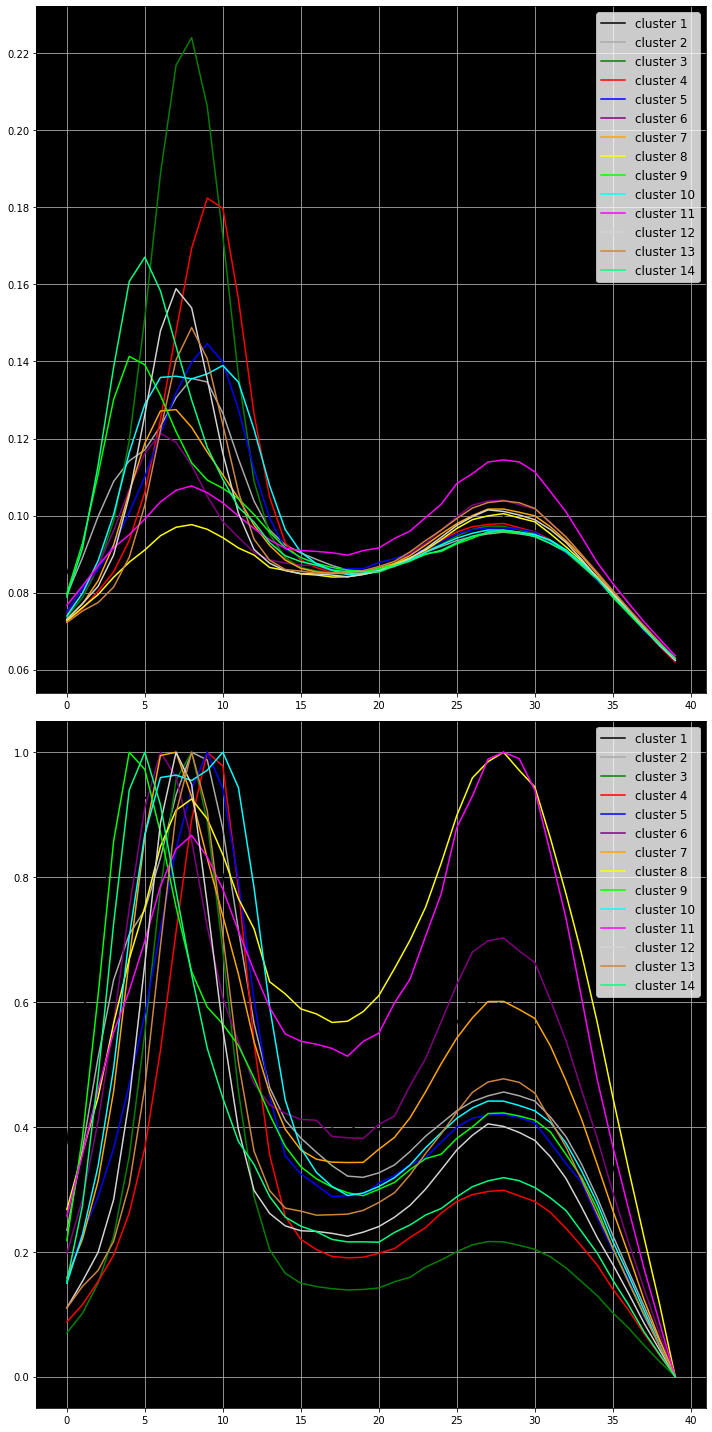

In [32]:
# cluster vs. cluster
lines = np.zeros((num_sel, s_dim))
sel_num = np.zeros(num_sel)

for h in range(num_img):
    for i in range(num_sel):
        for j in range(data_shape_new[h, 0]):
            for k in range(data_shape_new[h, 1]):
                if selected[i][h][j, k] == 1:
                    sel_num[i] += 1
                    lines[i] += reconstructed_reshape[h][j, k]
print(sel_num)
lines_nor = np.zeros((num_sel, s_dim))
for i in range(num_sel):
    lines_nor[i] = warp_scale(lines[i])

for i in range(num_sel):
    lines[i] /= sel_num[i]
            
fig11, ax11 = plt.subplots(2, 1, figsize=(10, 20))

for i in range(num_sel):
    ax11[0].plot(x_range, (lines[i]), label="cluster %d"%(i+1), c=color_rep[i])
    ax11[1].plot(x_range, (lines_nor[i]), label="cluster %d"%(i+1), c=color_rep[i])
ax11[0].grid()
ax11[0].set_facecolor("black")
ax11[0].legend(fontsize="large", loc="upper right")
ax11[1].grid()
ax11[1].set_facecolor("black")
ax11[1].legend(fontsize="large", loc="upper right")
fig11.tight_layout()

plt.show()

In [ ]:
plt.close(fig11)

In [ ]:
# cluster vs. cluster within an image
%matplotlib qt
lines = np.zeros((num_img, num_sel, s_dim))
sel_num = np.zeros((num_img, num_sel))

for h in range(num_img):
    for i in range(num_sel):
        for j in range(data_shape_new[h, 0]):
            for k in range(data_shape_new[h, 1]):
                if selected[i][h][j, k] == 1:
                    sel_num[h, i] += 1
                    lines[h, i] += reconstructed_reshape[h][j, k]

print(sel_num) 
#for h in range(num_img):            
#    for i in range(num_sel):
#        lines[h, i] = warp_scale(lines[h, i])

for h in range(num_img):
    for i in range(num_sel):
        lines[h, i] /= sel_num[h, i]
            
fig6, ax6 = plt.subplots(1, 1, figsize=(10, 10))

def img_selector(img_n):
    ax6.cla()
    for i in range(num_sel):
        ax6.plot((lines[img_n, i]), label="line %d"%(i+1), c=color_rep[i])
    ax6.grid()
    ax6.set_facecolor("black")
    fig6.canvas.draw()
    fig6.legend()
    fig6.tight_layout()
    
pyw.interact(img_selector, img_n=pyw.IntSlider(min=0, max=num_img-1, step=1, value=0))
plt.show()

In [ ]:
plt.close(fig6)

In [ ]:
# image vs. image depending on the component
%matplotlib qt
lines = np.zeros((num_img, num_sel, s_dim))
sel_num = np.zeros((num_img, num_sel))

for h in range(num_img):
    for i in range(num_sel):
        for j in range(data_shape_new[h, 0]):
            for k in range(data_shape_new[h, 1]):
                if selected[i][h][j, k] == 1:
                    sel_num[h, i] += 1
                    lines[h, i] += reconstructed_reshape[h][j, k]

print(sel_num) 
#for h in range(num_img):            
#    for i in range(num_sel):
#        lines[h, i] = warp_scale(lines[h, i])

for h in range(num_img):
    for i in range(num_sel):
        lines[h, i] /= sel_num[h, i]

#for h in range(num_img):
#    for i in range(num_sel):
#        lines[h, i] /= data_shape_new[h][0]*data_shape_new[h][1]
        
for h in range(num_img):
    lines[h] /= np.max(lines[h])
            
fig7, ax7 = plt.subplots(1, 1, figsize=(10, 10))

def comp_selector(n_sel):
    ax7.cla()
    for i in range(num_img):
        ax7.plot((lines[i, n_sel]), label="image %d"%(i+1), c=c=color_rep[i])
    ax7.grid()
    ax7.set_facecolor("black")
    fig7.canvas.draw()
    fig7.legend()
    fig7.tight_layout()
    
pyw.interact(comp_selector, n_sel=pyw.IntSlider(min=0, max=num_sel-1, step=1, value=0))
plt.show()

In [ ]:
plt.close(fig7)

In [ ]:
%matplotlib inline

In [ ]:
# vertical lines
%matplotlib qt
line_evolve = []
for i in range(num_img):
    line_evolve.append(np.sum(reconstructed_reshape[i], axis=0))
    
line_evolve = np.asarray(line_evolve)
#print(line_evolve[0].shape)

#for i in range(num_img):
#    for j in range(data_shape_new[i, 1]):
#        line_evolve[i][j] = warp_scale(line_evolve[i][j])
        
fig9, ax9 = plt.subplots(1, 1, figsize=(8, 12))
fig10, ax10 = plt.subplots(1, 1, figsize=(8, 10))

def img_selector(img_n, left, right):
    ax9.cla()
    ax10.cla()
    print("left: %d"%left)
    print("right: %d"%right)
    if right > data_shape_new[img_n, 1]:
        print("exceed the range of the image")
        
    elif left >= right:
        print("left must be smaller than right")
        
    else:
        for i in range(left, right, 1):
            ax9.plot(x_range, (line_evolve[img_n][-(i+1)]+i*10.0), c=color_cand[i], label="line %d"%(i+1))
            ax10.plot(x_range, line_evolve[img_n][-(i+1)], c=color_cand[i], label="line %d"%(i+1))
    ax9.grid()
    ax9.set_facecolor("black")
    ax10.grid()
    ax10.set_facecolor("black")
    fig9.canvas.draw()
    fig9.canvas.draw()
    fig10.tight_layout()
    fig10.tight_layout()

print(data_shape_new)
pyw.interact(img_selector, img_n=pyw.IntSlider(min=0, max=num_img-1, step=1, value=0), 
        left=pyw.IntSlider(min=0, max=np.max(data_shape_new[:, 1]), step=1, value=0), 
        right=pyw.IntSlider(min=0, max=np.max(data_shape_new[:, 1]), step=1, value=10))

plt.show()

In [ ]:
# horizontal lines
%matplotlib qt
line_evolve = []
for i in range(num_img):
    line_evolve.append(np.sum(reconstructed_reshape[i], axis=1))
    
line_evolve = np.asarray(line_evolve)
#print(line_evolve[0].shape)

#for i in range(num_img):
#    for j in range(data_shape_new[i, 1]):
#        line_evolve[i][j] = warp_scale(line_evolve[i][j])
        
fig7, ax7 = plt.subplots(1, 1, figsize=(8, 12))
ax7.tick_params(axis="both", labelsize=30)
fig8, ax8 = plt.subplots(1, 1, figsize=(8, 10))

def img_selector(img_n, top, bottom):
    ax7.cla()
    ax8.cla()
    print("top: %d"%top)
    print("bottom: %d"%bottom)
    if bottom > data_shape_new[img_n, 0]:
        print("exceed the range of the image")
        
    elif top >= bottom:
        print("top must be smaller than bottom")
        
    else:
        for i in range(top, bottom, 1):
            ax7.plot(x_range, (line_evolve[img_n][-(i+1)]+i*7.0), c=color_cand[i+30], label="line %d"%(i+1))
            ax8.plot(x_range, line_evolve[img_n][-(i+1)], c=color_cand[i+30], label="line %d"%(i+1))
    ax7.grid()
    #ax7.set_facecolor("black")
    ax8.grid()
    #ax8.set_facecolor("black")
    fig7.canvas.draw()
    fig8.canvas.draw()
    fig7.tight_layout()
    fig8.tight_layout()

print(data_shape_new)
pyw.interact(img_selector, img_n=pyw.IntSlider(min=0, max=num_img-1, step=1, value=0), 
        top=pyw.IntSlider(min=0, max=np.max(data_shape_new[:, 0]), step=1, value=0), 
        bottom=pyw.IntSlider(min=0, max=np.max(data_shape_new[:, 0]), step=1, value=10))

plt.show()